M5 Sales Forecasting - Accuracy Point Prediction
================================================

* [0 Global Definitions](#global-def)
* [1 Data Preparation](#data-preparation)
  * [1.1 Data Inspection and Visualization](#data-inspection)
    * [1.1.1 Inspect raw data tables](#inspect-raw-data)
    * [1.1.2 Plot sales time series](#plot-sales)
  * [1.2 Preprocess Sales Data](#preprocess-sales-data)
    * [1.2.1 Flatten Sales data](#flatten-sales-data)
    * [1.2.2 Add placeholding rows for test prediction](#add-placeholding-rows)
    * [1.2.3 Remove the leading 0-Sales entries before products went in-stock](#remove-leading-0-sales)
      * [1.2.3.1 Extract in-stock week from Prices data](#extract-in-stock-week)
      * [1.2.3.2 Extract current week from Calendar data](#extract-current-week)
      * [1.2.3.3 Remove the leading 0-Sales entries](#remove-leading-0-sale-entries)
    * [1.2.4 Convert IDs to Pandas Category for later use in lightgbm](#convert-ids-to-cat)
    * [1.2.5 Save flattened Sales data](#save-flattened-sales-data)
  * [1.3 Preprocess Weekly Price Data](#preprocess-weekly-price-data)
    * [1.3.1 Add summary statistical features to price series per store / item](#add-summary-stats-features)
    * [1.3.2 Add momentum features](#add-summary-stats-features)
    * [1.3.3 Re-index weekly Prices to flattend Sales index (id and d)](#reindex-weekly-prices-to-flat-sales)
    * [1.3.4 Save preprocessed Prices data](#save-preprocessed-prices-data)
  * [1.4 Preprocess Calendar data](#preprocess-calendar-data)
    * [1.4.1 Re-Index Calendar to the flattened Sales index (id and d)](#reindex-calendar-to-flat-sales)
    * [1.4.2 Convert event column types to category to save memory](#convert-event-column-types-to-cat)
    * [1.4.3 Convert date column and split to more features](#convert-date-column-split-features)
    * [1.4.4 Save preprocessed Calendar data](#save-preprocessed-calendar-data)
  * [1.5 Additional Cleaning](#additional-cleaning)
  * [1.6 Create lags and rolling mean / standard deviation](#create-lags-rolling-stats)
  * [1.7 Create mean / std for aggregation level 2-12 (Guide Table 1)](#create-stats-agg-level-2-12)
  * [1.8 Combine Sales, Prices and Calendar](#combine-sales-prices-calendar)
* [2 Modeling](#modeling)
  * [2.1 Hyperparameters](#hyperparameters)
  * [2.2 Train Models per Agg Level and IDs](#train-models-per-agg-level-ids)
  * [2.3 Combine Predictions to Submission](#combine-predictions-to-submission)

# Global definitions <a class="anchor" id="global-def"></a>

In [1]:
# Python libs
import warnings
import joblib
from pathlib import Path
from itertools import product
from math import ceil
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# Module settings
mpl.rc("figure", facecolor="white", dpi=196)
pd.set_option('display.max_columns', None)  # show all columns

In [2]:
DATA_INPUT_DIR = 'data_input/'
DATA_PROCESSED_DIR = 'data_processed/'
RESULTS_DIR = 'results/'

SALES_CSV = DATA_INPUT_DIR + 'sales_train_evaluation.csv'
PRICES_CSV = DATA_INPUT_DIR + 'sell_prices.csv'
CALENDAR_CSV = DATA_INPUT_DIR + 'calendar.csv'
SAMPLE_SUBMISSION_CSV = DATA_INPUT_DIR + 'sample_submission.csv'

SALES_DATA_FILE = DATA_PROCESSED_DIR + 'sales.pkl'
PRICES_DATA_FILE = DATA_PROCESSED_DIR + 'prices.pkl'
CALENDAR_DATA_FILE = DATA_PROCESSED_DIR + 'calendar.pkl'
SALES_PRICES_CALENDAR_DATA_FILE = DATA_PROCESSED_DIR + 'sales_prices_calendar.pkl'
SALES_LAG_ROLL_STATS_FILE = DATA_PROCESSED_DIR + 'sales_lag_roll_stats.pkl'
SALES_AGG_STATS_FILE = DATA_PROCESSED_DIR + 'sales_agg_stats.pkl'

SUBMISSION_FILE = RESULTS_DIR + 'submission.csv'

# Globals / Class attributes
FLAT_INDEX_COLS = ['id', 'd']
TARGET_COL = 'sales'
ID_D_TARGET_COLS = ['id', 'd', TARGET_COL]
END_TRAIN = 1941
SHIFT_DAY = 28

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] =-inspection df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# Data Preparation <a class="anchor" id="data-preparation"></a>

## Data Inspection and Visualization <a class="anchor" id="data-inspection"></a>

Three data files given:
- sales_train_evaluation.csv
- sell_prices.csv
- calendar.csv

In [4]:
sales = pd.read_csv(SALES_CSV)
prices = pd.read_csv(PRICES_CSV)
calendar = pd.read_csv(CALENDAR_CSV)

### Inspect raw data tables <a class="anchor" id="inspect-raw-data"></a>

In [5]:
sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
1         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
2         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
3         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
4         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
30485     WI_3       WI    0    0    2    2    0    3    1    4    1     0   
30486     WI_3       WI    0    0    0    0    0    5    0    1    1     3   
30487     WI_3       WI    0    6    0    2    2    4    1    8    5     2   
30488     WI_3       WI    0    0    0    0    0    0    0    0    0     0   
30489     WI_3       WI    0    0    0    0    0    0    0    0    0     0   

       d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     0     3     4     4     0     0     1     0     1     1     7     7   
30486     1     1     0     4     2     0     1     2     1     1     0     0   
30487     7     5     3     5    20     8    10     3     3     4     7     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2         0     0     0     0     0     0     0     0     0     0     0     0   
3         0     0     0     0     0     0     0     0     0     0     0     0   
4         0     0     0     0     0     0     0     0     0     0     0     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
30485     3     6     3     3     7    12     4     2     7     5    12     5   
30486     0     0     3     1     1     1     2     0     1     0     1     1   
30487     3     5     6     3     4     1     2     5     1     2     2     2   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
1         0     0     0     0     0     0     0     0     0     0     0     0   
2      

In [6]:
sales.info()
sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495      6.617729      5.917204      4.206199   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      314.000000    316.000000    370.000000    385.000000    353.000000   

               d_11          d_12          d_13          d_14          d_15  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.756674      0.775927      0.779141      0.867334      1.142440   
std        3.665969      3.697822      3.486595      3.484608      4.636395   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      279.000000    258.000000    163.000000    107.000000    133.000000   

               d_16          d_17          d_18          d_19          d_20  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.193178      0.715120      0.789439      0.703280      0.666382   
std        4.662770      2.993414      3.296922      2.811648      2.611911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      149.000000    122.000000    111.000000     83.000000     95.000000   

               d_21          d_22          d_23          d_24          d_25  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.777993      1.039324      0.960413      0.786028      0.672384   
std        2.985123      3.923110      3.597620      3.084773      2.874189   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      100.000000    132.000000    120.000000    113.000000    158.000000   

               d_26          d_27          d_28          d_29          d_30  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.680781      0.665038      0.738898      0.980912      0.941522   
std        2.727852      2.637849      2.842334      3.714944      3.688771   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000

In [7]:
prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [8]:
prices.info()
prices.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [9]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [10]:
calendar.info()
calendar.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


### Plot Sales time series <a class="anchor" id="plot-sales"></a>

At the beginning of the sales time series of each item, there could be some zeros, meaning the product was not available. So it's necessary to extract the 1st week when the item went in stock, and discard the 0 sales before that time point.

<AxesSubplot:>

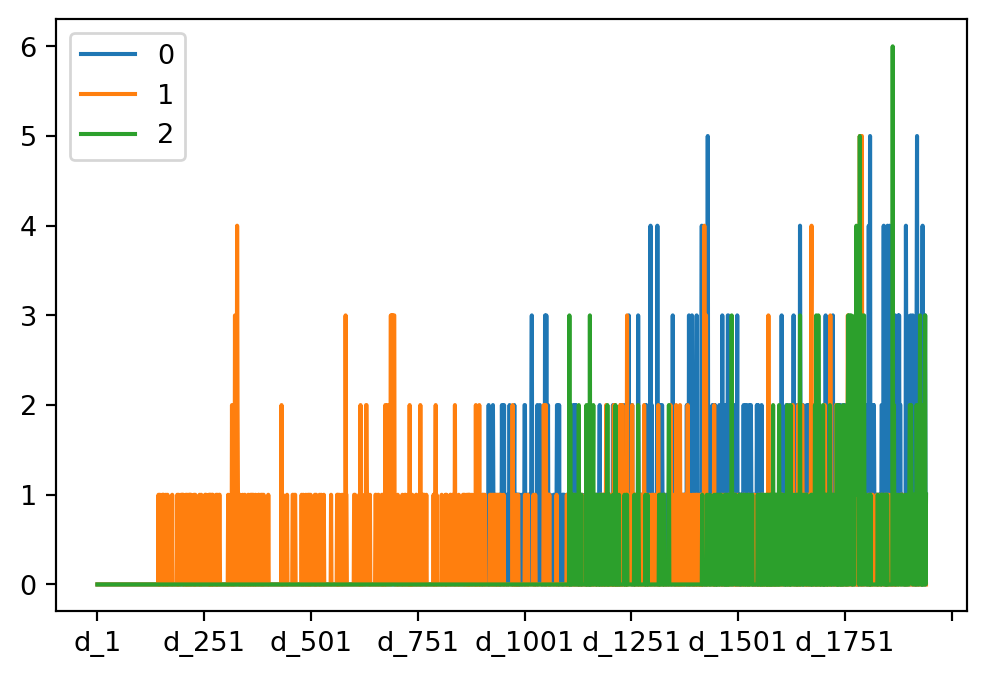

In [11]:
sales.iloc[:3][sales.columns[6:]].T.plot()

In [12]:
del sales, prices, calendar

## Preprocess Sales Data <a class="anchor" id="preprocess-sales-data"></a>

In [13]:
sales = pd.read_csv(SALES_CSV)
prices = pd.read_csv(PRICES_CSV)
calendar = pd.read_csv(CALENDAR_CSV)

### Flatten Sales data <a class="anchor" id="flatten-sales-data"></a>

In [14]:
id_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales = pd.melt(sales, id_vars=id_cols, var_name='d', value_name='sales')
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0


### Add placeholding rows for test prediction <a class="anchor" id="add-placeholding-rows"></a>

In [15]:
def add_test_rows(sales: pd.DataFrame, id_cols) -> pd.DataFrame:
    index_df = sales[id_cols].drop_duplicates()
    test_df = pd.DataFrame()
    for d in range(1, 29):
        df = index_df.copy()
        df['d'] = f'd_{END_TRAIN + d}'
        df[TARGET_COL] = np.nan
        test_df = pd.concat([test_df, df], axis=0)

    sales = pd.concat([sales, test_df]).reset_index(drop=True)
    return sales

sales = add_test_rows(sales, id_cols)
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,NaN


### Remove the leading 0-Sales entries before products went in-stock  <a class="anchor" id="remove-leading-0-sales"></a>

#### Extract in-stock week from Prices data <a class="anchor" id="extract-in-stock-week"></a>

In [16]:
instock = prices.groupby(['store_id', 'item_id'])['wm_yr_wk'].agg(['min']).reset_index()
instock.columns = list(instock)[:2] + ['instock_week']
instock

,store_id,item_id,instock_week
0,CA_1,FOODS_1_001,11101
1,CA_1,FOODS_1_002,11101
2,CA_1,FOODS_1_003,11101
3,CA_1,FOODS_1_004,11206
4,CA_1,FOODS_1_005,11101
...,...,...,...
30485,WI_3,HOUSEHOLD_2_512,11101
30486,WI_3,HOUSEHOLD_2_513,11311
30487,WI_3,HOUSEHOLD_2_514,11101
30488,WI_3,HOUSEHOLD_2_515,11352


In [17]:
sales = pd.merge(sales, instock, on=['store_id', 'item_id'], how='left')
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,instock_week
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11325
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11121
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11401
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11106
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11117
...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11331


In [18]:
del instock, prices

#### Extract current week from Calendar data <a class="anchor" id="extract-current-week"></a>

In [19]:
sales = pd.merge(sales, calendar[['wm_yr_wk', 'd']], on=['d'], how='left')
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,instock_week,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11325,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11121,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11401,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11106,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,11117,11101
...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101,11621
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101,11621
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11101,11621
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,NaN,11331,11621


In [20]:
del calendar

#### Remove the leading 0-Sales entries <a class="anchor" id="remove-leading-0-sale-entries"></a>

In [21]:
sales = sales.query("wm_yr_wk >= instock_week").reset_index(drop=True)
sales['instock_week'] = (sales['instock_week'] - sales['instock_week'].min()).astype(np.int16)  # minimize values to reduce memory

### Convert IDs to Pandas Category for later use in lightgbm   <a class="anchor" id="convert-ids-to-cat"></a>

Also reduce memory usage.

In [22]:
for col in id_cols:
    sales[col] = sales[col].astype('category')

### Save flattened Sales data <a class="anchor" id="save-flattened-sales-data"></a>

In [23]:

reduce_mem_usage(sales)
sales.to_pickle(SALES_DATA_FILE)
del sales

Mem. usage decreased to 1002.86 Mb (35.3% reduction)


## Preprocess Weekly Price Data <a class="anchor" id="preprocess-weekly-price-data"></a>

In [24]:
prices = pd.read_csv(PRICES_CSV)
calendar = pd.read_csv(CALENDAR_CSV)
sales = pd.read_pickle(SALES_DATA_FILE)

### Add summary statistical features to price series per store / item <a class="anchor" id="add-summary-stats-features"></a>

In [25]:
for feat in ['max', 'min', 'mean', 'std']:
    prices[f'price_{feat}'] = prices.groupby(['store_id', 'item_id'])['sell_price'].transform(feat)
prices['price_norm'] = prices['sell_price'] / prices['price_max']

prices['price_unique'] = prices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
prices['item_unique'] = prices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')

### Add momentum features <a class="anchor" id="add-summary-stats-features"></a>

In [26]:
# Add month/year columns from Calendar data for temporary use
prices = pd.merge(prices, calendar[['wm_yr_wk', 'month', 'year']].drop_duplicates(subset=['wm_yr_wk']), on=['wm_yr_wk'], how='left')

# Add momentum columns
prices['price_growth'] = prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices['price_deviation_month'] = prices['sell_price'] / prices.groupby(['store_id', 'item_id', 'month'])['sell_price'].transform('mean')
prices['price_deviation_year'] = prices['sell_price'] / prices.groupby(['store_id', 'item_id', 'year'])['sell_price'].transform('mean')

# Drop month/year columns
prices = prices.drop(['month', 'year'], axis=1)
prices

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_mean,price_std,price_norm,price_unique,item_unique,price_growth,price_deviation_month,price_deviation_year
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,8.285714,0.152139,1.000000,3,3,NaN,1.127059,1.145166
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,8.285714,0.152139,1.000000,3,3,1.000000,1.127059,1.145166
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,0.862213,0.971765,0.987377
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,1.000000,1.000000,0.987377
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,1.000000,1.000000,0.987377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00,1.00,1.00,1.000000,0.000000,1.000000,1,142,1.000000,1.000000,1.000000
6841117,WI_3,FOODS_3_827,11618,1.00,1.00,1.00,1.000000,0.000000,1.000000,1,142,1.000000,1.000000,1.000000
6841118,WI_3,FOODS_3_827,11619,1.00,1.00,1.00,1.000000,0.000000,1.000000,1,142,1.000000,1.000000,1.000000
6841119,WI_3,FOODS_3_827,11620,1.00,1.00,1.00,1.000000,0.000000,1.000000,1,142,1.000000,1.000000,1.000000


### Re-index weekly Prices to flattend Sales index (id and d) <a class="anchor" id="reindex-weekly-prices-to-flat-sales"></a>

In [27]:
on_cols = ['store_id', 'item_id', 'wm_yr_wk']
prices = pd.merge(sales[FLAT_INDEX_COLS + on_cols], prices, on=on_cols, how='left').drop(on_cols, axis=1)
prices

,id,d,sell_price,price_max,price_min,price_mean,price_std,price_norm,price_unique,item_unique,price_growth,price_deviation_month,price_deviation_year
0,HOBBIES_1_008_CA_1_evaluation,d_1,0.46,0.50,0.42,0.476312,0.019764,0.920000,4,16,NaN,0.968864,0.949452
1,HOBBIES_1_009_CA_1_evaluation,d_1,1.56,1.77,1.56,1.764787,0.032731,0.881356,2,9,NaN,0.885926,0.896552
2,HOBBIES_1_010_CA_1_evaluation,d_1,3.17,3.17,2.97,2.981348,0.046350,1.000000,2,20,NaN,1.064224,1.044376
3,HOBBIES_1_012_CA_1_evaluation,d_1,5.98,6.52,5.98,6.469504,0.115991,0.917178,3,71,NaN,0.922035,0.959180
4,HOBBIES_1_015_CA_1_evaluation,d_1,0.70,0.72,0.68,0.706596,0.011339,0.972222,3,16,NaN,0.990160,1.001752
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_823_WI_3_evaluation,d_1969,2.98,2.98,2.48,2.801560,0.171600,1.000000,5,206,1.0,1.031856,1.022790
47735393,FOODS_3_824_WI_3_evaluation,d_1969,2.48,2.68,2.00,2.507979,0.253165,0.925373,4,135,1.0,0.986005,1.111908
47735394,FOODS_3_825_WI_3_evaluation,d_1969,3.98,4.38,3.98,4.115957,0.188591,0.908676,3,150,1.0,0.957652,1.000000
47735395,FOODS_3_826_WI_3_evaluation,d_1969,1.28,1.28,1.28,1.280000,0.000000,1.000000,1,44,1.0,1.000000,1.000000


### Save preprocessed Prices data <a class="anchor" id="save-preprocessed-prices-data"></a>

In [28]:
reduce_mem_usage(prices)
prices.to_pickle(PRICES_DATA_FILE)
del prices, sales

Mem. usage decreased to 1776.68 Mb (63.2% reduction)


## Preprocess Calendar data <a class="anchor" id="preprocess-calendar-data"></a>

### Re-Index Calendar to the flattened Sales index (id and d) <a class="anchor" id="reindex-calendar-to-flat-sales"></a>

In [29]:
prices = pd.read_csv(CALENDAR_CSV)
sales = pd.read_pickle(SALES_DATA_FILE)

In [30]:
cal_index_cols = ["date", "d"]
cal_event_cols = [
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]

calendar = pd.merge(sales[FLAT_INDEX_COLS], calendar[cal_index_cols+cal_event_cols], on=['d'], how='left')

### Convert event column types to category to save memory <a class="anchor" id="convert-event-column-types-to-cat"></a>

In [31]:
for col in cal_event_cols:
    calendar[col] = calendar[col].astype('category')

### Convert date column and split to more features <a class="anchor" id="convert-date-column-split-features"></a>

In [32]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['day'] = calendar['date'].dt.day.astype(np.int8)
calendar['week'] = calendar['date'].dt.isocalendar().week.astype(np.int8)
calendar['month'] = calendar['date'].dt.month.astype(np.int8)
calendar['year'] = (calendar['date'].dt.year - calendar['date'].dt.year.min()).astype(np.int8)
calendar['week_of_month'] = calendar['day'].apply(lambda day: ceil(day/7)).astype(np.int8)
calendar['weekday'] = calendar['date'].dt.dayofweek.astype(np.int8)
calendar['weekend'] = (calendar['weekday'] >= 5).astype(np.int8)

calendar.drop('date', axis=1, inplace=True)
calendar


,id,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,week,month,year,week_of_month,weekday,weekend
0,HOBBIES_1_008_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
1,HOBBIES_1_009_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
2,HOBBIES_1_010_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
3,HOBBIES_1_012_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
4,HOBBIES_1_015_CA_1_evaluation,d_1,NaN,NaN,NaN,NaN,0,0,0,29,4,1,0,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_823_WI_3_evaluation,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,19,24,6,5,3,6,1
47735393,FOODS_3_824_WI_3_evaluation,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,19,24,6,5,3,6,1
47735394,FOODS_3_825_WI_3_evaluation,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,19,24,6,5,3,6,1
47735395,FOODS_3_826_WI_3_evaluation,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,19,24,6,5,3,6,1


### Save preprocessed Calendar data <a class="anchor" id="save-preprocessed-calendar-data"></a>

In [33]:
reduce_mem_usage(calendar)
calendar.to_pickle(CALENDAR_DATA_FILE)
del calendar, sales

Mem. usage decreased to 1458.01 Mb (0.0% reduction)


## Additional Cleaning <a class="anchor" id="additional-cleaning"></a>

In [34]:
sales = pd.read_pickle(SALES_DATA_FILE)

# Convert 'd' column to int
sales['d'] = sales['d'].apply(lambda x: x[2:]).astype(np.int16)

# Drop wm_yr_wk
sales.drop('wm_yr_wk', axis=1, inplace=True)


sales
sales.info()

sales.to_pickle(SALES_DATA_FILE)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,instock_week
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12.0,0
1,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2.0,0
2,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0
3,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,0
4,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4.0,0
...,...,...,...,...,...,...,...,...,...
47735392,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,0
47735393,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,0
47735394,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,0
47735395,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,230


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47735397 entries, 0 to 47735396
Data columns (total 9 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             int16   
 7   sales         float16 
 8   instock_week  int16   
dtypes: category(6), float16(1), int16(2)
memory usage: 638.7 MB


## Create lags and rolling mean / standard deviation <a class="anchor" id="create-lags-rolling-stats"></a>

In [35]:
sales = pd.read_pickle(SALES_DATA_FILE)

In [36]:
sales_lags_rolling = sales[FLAT_INDEX_COLS + [TARGET_COL]].copy()
del sales

In [37]:
# Lags from 28 days to 28 + 15 days
n_lag_days = 15
sales_lags_rolling = sales_lags_rolling.assign(**{
        f'{TARGET_COL}_lag_{lag_i}': sales_lags_rolling.groupby(['id'])[TARGET_COL].transform(lambda x: x.shift(lag_i)).astype(np.float16)
        for lag_i in range(SHIFT_DAY, SHIFT_DAY + n_lag_days)
    })

In [38]:
# Rollings on 28-day shift with different window lengths
win_lens = [7, 14, 30, 60, 180]
for window in win_lens:
    sales_lags_rolling['rolling_mean_'+str(window)] = sales_lags_rolling.groupby(['id'])[TARGET_COL].transform(lambda x: x.shift(SHIFT_DAY).rolling(window).mean()).astype(np.float16)
    sales_lags_rolling['rolling_std_'+str(window)]  = sales_lags_rolling.groupby(['id'])[TARGET_COL].transform(lambda x: x.shift(SHIFT_DAY).rolling(window).std()).astype(np.float16)

In [39]:
# Rollings on sliding shifts with different window lengths
shift_days = [1, 7, 14]
win_lens = [7, 14, 30, 60]
for shift_d in shift_days:
    for window in win_lens:
        col = f"rolling_mean_shift{shift_d}_win{window}"
        sales_lags_rolling[col] = sales_lags_rolling.groupby(['id'])[TARGET_COL].transform(lambda x: x.shift(shift_d).rolling(window).mean()).astype(np.float16)

In [40]:
reduce_mem_usage(sales_lags_rolling)
sales_lags_rolling.to_pickle(SALES_LAG_ROLL_STATS_FILE)
del sales_lags_rolling

Mem. usage decreased to 3643.16 Mb (0.0% reduction)


## Create mean / std for aggregation level 2-12 (Guide Table 1) <a class="anchor" id="create-stats-agg-level-2-12"></a>

In [41]:
sales = pd.read_pickle(SALES_DATA_FILE)

In [42]:
# Empty result dataframe
sales_agg_stats = sales[FLAT_INDEX_COLS].copy()

# remove validation labels
val_index = sales.query(f"d > {1941 - 28}").index
sales.loc[val_index, TARGET_COL] = np.nan

# Level columns according to Table 1 in the Guide document
level_cols = [
    ["state_id"],
    ["store_id"],
    ["cat_id"],
    ["dept_id"],
    ["state_id", "cat_id"],
    ["state_id", "dept_id"],
    ["store_id", "cat_id"],
    ["store_id", "dept_id"],
    ["item_id"],
    ["item_id", "state_id"],
    ["item_id", "store_id"],
]

# Create mean / std of sales for each level
for level_i, level_col in enumerate(level_cols, start=2):
    col = f"level{level_i}_" + "_".join(level_col)
    sales_agg_stats[col + '_mean'] = sales.groupby(level_col)["sales"].transform("mean").astype(np.float16)
    sales_agg_stats[col + '_std'] = sales.groupby(level_col)["sales"].transform("std").astype(np.float16)

In [43]:
reduce_mem_usage(sales_agg_stats)
sales_agg_stats.to_pickle(SALES_AGG_STATS_FILE)
del sales_agg_stats, sales

Mem. usage decreased to 2185.39 Mb (0.0% reduction)


## Combine Sales, Prices and Calendar <a class="anchor" id="combine-sales-prices-calendar"></a>

In [44]:
sales = pd.read_pickle(SALES_DATA_FILE)
prices = pd.read_pickle(PRICES_DATA_FILE)
calendar = pd.read_pickle(CALENDAR_DATA_FILE)

In [45]:
sales.columns
prices.columns
calendar.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'instock_week'],
      dtype='object')

Index(['id', 'd', 'sell_price', 'price_max', 'price_min', 'price_mean',
       'price_std', 'price_norm', 'price_unique', 'item_unique',
       'price_growth', 'price_deviation_month', 'price_deviation_year'],
      dtype='object')

Index(['id', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'day', 'week', 'month',
       'year', 'week_of_month', 'weekday', 'weekend'],
      dtype='object')

In [46]:
sales.shape
prices.shape
calendar.shape

(47735397, 9)

(47735397, 13)

(47735397, 16)

In [47]:
data_processed = pd.concat([sales, prices[prices.columns[2:]], calendar[calendar.columns[2:]]], axis=1)
data_processed.to_pickle(SALES_PRICES_CALENDAR_DATA_FILE)

# Modeling <a class="anchor" id="modeling"></a>
Run Global definitions before run this section.

## Hyperparameters <a class="anchor" id="hyperparameters"></a>

In [3]:
# data = pd.read_pickle(SALES_PRICES_CALENDAR_DATA_FILE)
# IDs_ALL = {
#     "store_id": data['store_id'].unique().tolist(),
#     "cat_id": data['cat_id'].unique().tolist(),
#     "dept_id": data['dept_id'].unique().tolist(),
# }
IDs_ALL = {
    "store_id": [
        "CA_1",
        "CA_2",
        "CA_3",
        "CA_4",
        "TX_1",
        "TX_2",
        "TX_3",
        "WI_1",
        "WI_2",
        "WI_3",
    ],
    "cat_id": ["HOBBIES", "HOUSEHOLD", "FOODS"],
    "dept_id": [
        "HOBBIES_1",
        "HOBBIES_2",
        "HOUSEHOLD_1",
        "HOUSEHOLD_2",
        "FOODS_1",
        "FOODS_2",
        "FOODS_3",
    ],
}

In [4]:
# sales_lag_rolling_stats_cols = pd.read_pickle(SALES_LAG_ROLL_STATS_FILE).columns
# sales_agg_stats_cols = pd.read_pickle(SALES_AGG_STATS_FILE).columns
sales_lag_rolling_stats_cols = [
    "id",
    "d",
    "sales",
    "sales_lag_28",
    "sales_lag_29",
    "sales_lag_30",
    "sales_lag_31",
    "sales_lag_32",
    "sales_lag_33",
    "sales_lag_34",
    "sales_lag_35",
    "sales_lag_36",
    "sales_lag_37",
    "sales_lag_38",
    "sales_lag_39",
    "sales_lag_40",
    "sales_lag_41",
    "sales_lag_42",
    "rolling_mean_7",
    "rolling_std_7",
    "rolling_mean_14",
    "rolling_std_14",
    "rolling_mean_30",
    "rolling_std_30",
    "rolling_mean_60",
    "rolling_std_60",
    "rolling_mean_180",
    "rolling_std_180",
    "rolling_mean_shift1_win7",
    "rolling_mean_shift1_win14",
    "rolling_mean_shift1_win30",
    "rolling_mean_shift1_win60",
    "rolling_mean_shift7_win7",
    "rolling_mean_shift7_win14",
    "rolling_mean_shift7_win30",
    "rolling_mean_shift7_win60",
    "rolling_mean_shift14_win7",
    "rolling_mean_shift14_win14",
    "rolling_mean_shift14_win30",
    "rolling_mean_shift14_win60",
]
sales_agg_stats_cols = [
    "id",
    "d",
    "level2_state_id_mean",
    "level2_state_id_std",
    "level3_store_id_mean",
    "level3_store_id_std",
    "level4_cat_id_mean",
    "level4_cat_id_std",
    "level5_dept_id_mean",
    "level5_dept_id_std",
    "level6_state_id_cat_id_mean",
    "level6_state_id_cat_id_std",
    "level7_state_id_dept_id_mean",
    "level7_state_id_dept_id_std",
    "level8_store_id_cat_id_mean",
    "level8_store_id_cat_id_std",
    "level9_store_id_dept_id_mean",
    "level9_store_id_dept_id_std",
    "level10_item_id_mean",
    "level10_item_id_std",
    "level11_item_id_state_id_mean",
    "level11_item_id_state_id_std",
    "level12_item_id_store_id_mean",
    "level12_item_id_store_id_std",
]


In [5]:
loop_cols_L3_store = ['store_id']
loop_cols_L8_store_cat = ['store_id', 'cat_id']
loop_cols_L9_store_dept = ['store_id', 'dept_id']

drop_cols_L3_store = ['state_id', 'store_id']
drop_cols_L8_store_cat = ['state_id', 'store_id', 'cat_id']
drop_cols_L9_store_dept = ['state_id', 'store_id', 'cat_id', 'dept_id']

rec_lag_rolling_cols = sales_lag_rolling_stats_cols[3:]
nonrec_lag_rolling_cols = [f'sales_lag_{i}' for i in range(28, 43)] + [f'rolling_{stat}_{i}' for i in (7, 14, 30, 60, 180) for stat in ('mean', 'std')]

rec_agg_stats_cols_L3_store = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level4', 'level5', 'level10')]
rec_agg_stats_cols_L8_store_cat = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level9', 'level12')]
rec_agg_stats_cols_L9_store_dept = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level12',)]

nonrec_agg_stats_cols_L3_store = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level9', 'level11')]
nonrec_agg_stats_cols_L8_store_cat = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level9', 'level12')]
nonrec_agg_stats_cols_L9_store_dept = [col for col in sales_agg_stats_cols if col.split('_')[0] in ('level12',)]

rec_start_d_L3 = 0
rec_start_d_L8 = 700
rec_start_d_L9 = 700
rec_num_leaves_L3 = 2*11 - 1
rec_num_leaves_L8 = 2**8 - 1
rec_num_leaves_L9 = 2**8 - 1
rec_min_data_in_leaf_L3 = 2**12 - 1
rec_min_data_in_leaf_L8 = 2**8 - 1
rec_min_data_in_leaf_L9 = 2**8 - 1

nonrec_start_d = 710
nonrec_num_leaves = 2**8 - 1
nonrec_min_data_in_leaf = 2**8 - 1

In [6]:
feature_hyperparas = {
    "rec_L3_store": {
        "loop_cols": loop_cols_L3_store,
        "drop_cols": drop_cols_L3_store,
        "lag_rolling_cols": rec_lag_rolling_cols,
        "agg_stats_cols": rec_agg_stats_cols_L3_store,
        "start_d": rec_start_d_L3,
        "num_leaves": rec_num_leaves_L3,
        "min_data_in_leaf": rec_min_data_in_leaf_L3,
    },

    "rec_L8_store_cat": {
        "loop_cols": loop_cols_L8_store_cat,
        "drop_cols": drop_cols_L8_store_cat,
        "lag_rolling_cols": rec_lag_rolling_cols,
        "agg_stats_cols": rec_agg_stats_cols_L8_store_cat,
        "start_d": rec_start_d_L8,
        "num_leaves": rec_num_leaves_L8,
        "min_data_in_leaf": rec_min_data_in_leaf_L8,
    },

    "rec_L9_store_dept": {
        "loop_cols": loop_cols_L9_store_dept,
        "drop_cols": drop_cols_L9_store_dept,
        "lag_rolling_cols": rec_lag_rolling_cols,
        "agg_stats_cols": rec_agg_stats_cols_L9_store_dept,
        "start_d": rec_start_d_L9,
        "num_leaves": rec_num_leaves_L9,
        "min_data_in_leaf": rec_min_data_in_leaf_L9,
    },

    "nonrec_L3_store": {
        "loop_cols": loop_cols_L3_store,
        "drop_cols": drop_cols_L3_store,
        "lag_rolling_cols": nonrec_lag_rolling_cols,
        "agg_stats_cols": nonrec_agg_stats_cols_L3_store,
        "start_d": nonrec_start_d,
        "num_leaves": nonrec_num_leaves,
        "min_data_in_leaf": nonrec_min_data_in_leaf,
    },

    "nonrec_L8_store_cat": {
        "loop_cols": loop_cols_L8_store_cat,
        "drop_cols": drop_cols_L8_store_cat,
        "lag_rolling_cols": nonrec_lag_rolling_cols,
        "agg_stats_cols": nonrec_agg_stats_cols_L8_store_cat,
        "start_d": nonrec_start_d,
        "num_leaves": nonrec_num_leaves,
        "min_data_in_leaf": nonrec_min_data_in_leaf,
    },

    "nonrec_L9_store_dept": {
        "loop_cols": loop_cols_L9_store_dept,
        "drop_cols": drop_cols_L9_store_dept,
        "lag_rolling_cols": nonrec_lag_rolling_cols,
        "agg_stats_cols": nonrec_agg_stats_cols_L9_store_dept,
        "start_d": nonrec_start_d,
        "num_leaves": nonrec_num_leaves,
        "min_data_in_leaf": nonrec_min_data_in_leaf,
    },
}

lgb_hyperparas = {
    "boosting": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "metric": "rmse",
    "bagging_fraction": 0.5,
    "bagging_freq": 1,
    "learning_rate": 0.015,
    "num_leaves": 2 ** 8 - 1,
    "min_data_in_leaf": 2 ** 8 - 1,
    "feature_fraction": 0.5,
    "max_bin": 100,
    "num_iterations": 3000,
    "boost_from_average": False,
    "verbosity": -1,  # FATAL, suppress lgb warnings
    "seed": 1995,
    "num_threads": 10
}

## Train Models per Agg Level and IDs <a class="anchor" id="train-models-per-agg-level-ids"></a>

In [7]:
def get_data_for_modeling(loop_ids: tuple, hyperparas: dict) -> tuple:
    """
    Read data and Filter / Merge features per aggregation level and IDs.
    """

    global ID_D_TARGET_COLS
    global SALES_PRICES_CALENDAR_DATA_FILE, SALES_LAG_ROLL_STATS_FILE, SALES_AGG_STATS_FILE

    print("Load SALES_PRICES_CALENDAR_DATA_FILE ...")
    data = pd.read_pickle(SALES_PRICES_CALENDAR_DATA_FILE)
    
    # Cut off from starting day
    print("Cut off from starting day ...")
    data = data[data['d'] >= hyperparas['start_d']]
    
    # Filter data by agg level ids
    print("Create agg id filter mask ...")
    id_mask = True
    for loop_col, loop_val in zip(hyperparas['loop_cols'], loop_ids):
        id_mask &= (data[loop_col] == loop_val)
    data = data[id_mask]

    # Drop aggregated id columns
    data = data.drop(hyperparas['drop_cols'], axis=1)

    # Lags / rollings features
    print("Load lag rolling stats ...")
    df_lags_rolling = pd.read_pickle(SALES_LAG_ROLL_STATS_FILE)[hyperparas['lag_rolling_cols']]
    df_lags_rolling = df_lags_rolling[df_lags_rolling.index.isin(data.index)]

    # Agg mean/std features
    print("Load agg stats ...")
    df_agg_mean_std = pd.read_pickle(SALES_AGG_STATS_FILE)[hyperparas['agg_stats_cols']]
    df_agg_mean_std = df_agg_mean_std[df_agg_mean_std.index.isin(data.index)]

    # Merge data
    print("Merge data with stats ...")
    data = pd.concat([data, df_lags_rolling, df_agg_mean_std], axis=1).reset_index(drop=True)
    features = [col for col in data.columns if col not in ID_D_TARGET_COLS]

    return data, features




In [8]:
def get_train_val_test_data(loop_ids, hyperparas):
    global END_TRAIN, SHIFT_DAY, TARGET_COL, FLAT_INDEX_COLS
    
    data, features = get_data_for_modeling(loop_ids, hyperparas)

    train_mask = data['d'] <= END_TRAIN
    valid_mask = (data['d'] > END_TRAIN - SHIFT_DAY) & train_mask
    test_mask = ~train_mask

    train = lgb.Dataset(data[train_mask][features], label=data[train_mask][TARGET_COL])

    X_valid = data[valid_mask][features]
    valid = lgb.Dataset(X_valid, label=data[valid_mask][TARGET_COL])
    id_valid = data[valid_mask][FLAT_INDEX_COLS]
    id_valid['id'] = id_valid['id'].str.replace('evaluation', 'validation')

    test = data[test_mask]
    X_test = test[features]
    id_test = test[FLAT_INDEX_COLS]

    return train, valid, X_valid, id_valid, X_test, id_test

def train_one_model(train, valid, hyperparas: dict, lgb_hyperparas=lgb_hyperparas) -> None:
    """
    At a particular aggregation level, train one model for a particular id group (e.g. store_id and cat_id).
    """
    # Update parameters
    lgb_hyperparas = lgb_hyperparas.copy()
    lgb_hyperparas['num_leaves'] = hyperparas['num_leaves']
    lgb_hyperparas['min_data_in_leaf'] = hyperparas['min_data_in_leaf']

    # Train
    random.seed(42)
    np.random.seed(42)
    warnings.filterwarnings('ignore')
    model = lgb.train(lgb_hyperparas, train, valid_sets=[valid, train], callbacks=[lgb.log_evaluation(period=100)])
    warnings.filterwarnings('default')

    # Feature importace
    featimp = pd.DataFrame({'feature': model.feature_name(), 'importance': model.feature_importance()}).sort_values('importance', ascending=False)

    return model, featimp

def predict_one_model(X_test: pd.DataFrame, id_test: pd.DataFrame, model):
    global TARGET_COL
    
    id_test[TARGET_COL] = model.predict(X_test)
    return id_test

def train_predict_one_level(agg_level, feature_hyperparas=feature_hyperparas):
    global IDs_ALL
    hyperparas = feature_hyperparas[agg_level]
    loop_ids_all = list(product(*(IDs_ALL[col] for col in hyperparas['loop_cols'])))
    results = {}

    for loop_ids in loop_ids_all:
        print(f'\n=== Train / Predict {agg_level} - {loop_ids} ===')

        print("Get data and split to Train / Validation / Test ...")
        train, valid, X_valid, id_valid, X_test, id_test = get_train_val_test_data(loop_ids, hyperparas)

        print("Train model ...")
        model, featimp = train_one_model(train, valid, hyperparas)

        print("Predict ...")
        val_pred = predict_one_model(X_valid, id_valid, model)
        test_pred = predict_one_model(X_test, id_test, model)

        # Save results
        print("Dump model and results ...")
        loop_ids_str = '_'.join(list(loop_ids))
        results[loop_ids_str] = {
            'model': model,
            'feature_importance': featimp,
            'val_pred': val_pred,
            'test_pred': test_pred,
        }
        joblib.dump(results, f'{agg_level}.pkl')  # overwrite at each iteration




In [ ]:
train_predict_one_level('rec_L3_store')
train_predict_one_level('rec_L8_store_cat')
train_predict_one_level('rec_L9_store_dept')
train_predict_one_level('nonrec_L3_store')
train_predict_one_level('nonrec_L8_store_cat')
train_predict_one_level('nonrec_L9_store_dept')

## Combine Predictions to Submission <a class="anchor" id="combine-predictions-to-submission"></a>

In [5]:
result_files = [RESULTS_DIR + f for f in ('rec_L3_store.pkl', 'rec_L8_store_cat.pkl', 'rec_L9_store_dept.pkl', 'nonrec_L3_store.pkl', 'nonrec_L8_store_cat.pkl', 'nonrec_L9_store_dept.pkl')]

def combine_predictions(result_files=result_files):
    sample = pd.read_csv(SAMPLE_SUBMISSION_CSV).set_index('id')

    pred_list = []
    for result_f in result_files:
        print(f"Process {result_f}")
        result = joblib.load(result_f)
        val_pred = pd.concat((r['val_pred'] for r in result.values()), axis=0)
        test_pred = pd.concat((r['test_pred'] for r in result.values()), axis=0)
        val_pred = val_pred.pivot(index='id', columns='d', values=TARGET_COL)
        test_pred = test_pred.pivot(index='id', columns='d', values=TARGET_COL)
        val_pred.columns = [f'F{i}' for i in range(1, 29)]
        test_pred.columns = [f'F{i}' for i in range(1, 29)]
        pred = pd.concat([val_pred, test_pred], axis=0)
        pred = pred.reindex(sample.index)
        pred_list.append(pred)

    pred = sum(pred_list) / len(pred_list)
    pred.to_csv(SUBMISSION_FILE, index=True)

combine_predictions()

Process results/rec_L3_store.pkl
Process results/rec_L8_store_cat.pkl
Process results/rec_L9_store_dept.pkl
Process results/nonrec_L3_store.pkl
Process results/nonrec_L8_store_cat.pkl
Process results/nonrec_L9_store_dept.pkl
